In [3]:
import pandas as pd
import smile_extract
from pathlib import Path
import numpy as np
import scipy.signal as scs
import src
import seaborn as sns

In [4]:
folder = Path('/Users/raeed/Library/CloudStorage/OneDrive-UniversityofPittsburgh/0-projects/cst-rtt/cst-data/preTD/Dwight/2025-01-07/')
# folder = Path('/Users/raeed/Library/CloudStorage/OneDrive-UniversityofPittsburgh/0-projects/cst-rtt/cst-data/preTD/Prez/')
files = [
    folder / 'Dwight_2025-01-07_reward-type_medium_cst-rtt-dco_sorted.mat',
    folder / 'Dwight_2025-01-01_reward-type_medium-large_cst-rtt-dco_sorted.mat',
]
# files = [ folder / 'Prez20220721_handControl_SI_sort.mat' ]
smile_data = smile_extract.direct_load_smile_data(files[0])


In [5]:
state_mapper = {
    'Hold Center (CST Cue)': 'Hold Center (Task Cue)',
    'Hold Center (RTT Cue)': 'Hold Center (Task Cue)',
}
tf = (
    smile_extract.compose_session_frame(smile_data)
    .loc[:,['task','result','state','hand position','motor cortex']]
    .set_index(['task','result','state'],append=True)
    .xs(level='result',key='success')
    .rename(index=state_mapper,level='state')
)
tf

channel                                              hand position  \
signal                                                           x   
trial_id time                   task state                           
1        0 days 00:00:00        RTT  Reach to Center     61.511639   
         0 days 00:00:00.010000 RTT  Reach to Center     61.523815   
         0 days 00:00:00.020000 RTT  Reach to Center     61.523992   
         0 days 00:00:00.030000 RTT  Reach to Center     61.528734   
         0 days 00:00:00.040000 RTT  Reach to Center     61.521756   
...                                                            ...   
152      0 days 00:00:04.340000 CST  Success            131.019076   
         0 days 00:00:04.350000 CST  Success            130.678476   
         0 days 00:00:04.360000 CST  Success            130.328765   
         0 days 00:00:04.370000 CST  Success            129.983302   
         0 days 00:00:04.380000 CST  Success            129.675428   

channel                                                                      \
signal                                                         y          z   
trial_id time                   task state                                    
1        0 days 00:00:00        RTT  Reach to Center  796.000308  45.378573   
         0 days 00:00:00.010000 RTT  Reach to Center  796.008314  45.383986   
         0 days 00:00:00.020000 RTT  Reach to Center  796.014579  45.373014   
         0 days 00:00:00.030000 RTT  Reach to Center  796.005679  45.383058   
         0 days 00:00:00.040000 RTT  Reach to Center  795.999943  45.400846   
...                                                          ...        ...   
152      0 days 00:00:04.340000 CST  Success          899.375467  11.113030   
         0 days 00:00:04.350000 CST  Success          899.449719  11.031885   
         0 days 00:00:04.360000 CST  Success          899.540967  10.946598   
         0 days 00:00:04.370000 CST  Success          899.620873  10.865358   
         0 days 00:00:04.380000 CST  Success          899.682388  10.795263   

channel                                              motor cortex              \
signal                                                      ch6u1 ch9u1 ch9u2   
trial_id time                   task state                                      
1        0 days 00:00:00        RTT  Reach to Center            0     0     0   
         0 days 00:00:00.010000 RTT  Reach to Center            0     1     0   
         0 days 00:00:00.020000 RTT  Reach to Center            0     0     0   
         0 days 00:00:00.030000 RTT  Reach to Center            0     0     1   
         0 days 00:00:00.040000 RTT  Reach to Center            1     0     0   
...                                                           ...   ...   ...   
152      0 days 00:00:04.340000 CST  Success                    0     1     0   
         0 days 00:00:04.350000 CST  Success                    0     0     1   
         0 days 00:00:04.360000 CST  Success                    0     0     0   
         0 days 00:00:04.370000 CST  Success                    0     1     0   
         0 days 00:00:04.380000 CST  Success                    1     0     0   

channel                                                                   \
signal                                               ch9u3 ch10u1 ch12u1   
trial_id time                   task state                                 
1        0 days 00:00:00        RTT  Reach to Center     0      0      0   
         0 days 00:00:00.010000 RTT  Reach to Center     0      0      0   
         0 days 00:00:00.020000 RTT  Reach to Center     0      0      0   
         0 days 00:00:00.030000 RTT  Reach to Center     0      0      0   
         0 days 00:00:00.040000 RTT  Reach to Center     0      0      0   
...                                                    ...    ...    ...   
152      0 days 00:00:04.340000 CST  Success             0      0      0   
         0 days 0

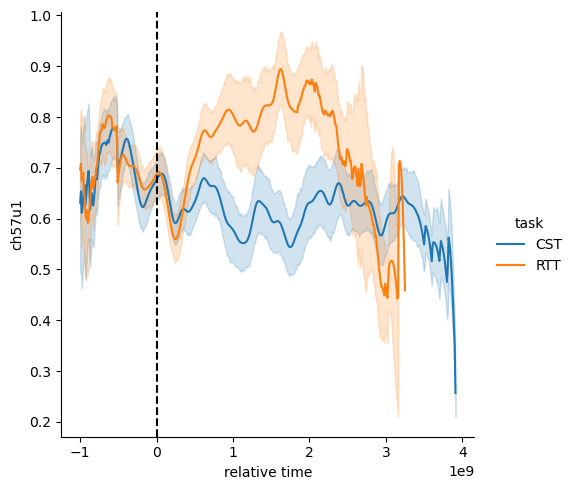

In [7]:
def reindex_trial_from_event(trial,event):
    try:
        reference_time = (
            trial
            .pipe(src.munge.get_index_level,level='state')
            .pipe(src.munge.get_state_transition_times,timecol='time')
            .xs(level='new_state',key=event)
            .values[-1]
        )
    except KeyError:
        reference_time = pd.NaT

    return (
        trial
        .rename(
            index= lambda time: time-reference_time,
            level='time',
        )
        .rename_axis(index={'time': 'relative time'})
    )

temp = (
    pd.concat([
        tf.xs('CST',level='task',drop_level=False),
        tf.xs('RTT',level='task',drop_level=False),
    ])
    ['motor cortex']
    .groupby('trial_id')
    .transform(smile_extract.smooth_data,dt=0.01,std=0.05,backend='convolve')
    .groupby('trial_id',group_keys=False)
    .apply(reindex_trial_from_event,event='Hold Center (Task Cue)')
    .loc[(slice(None),slice('-1 sec','4 sec')),:]
)
# src.munge.get_epoch_data(temp.xs(level='result',key='success'),epochs={'Hold Center (Task Cue)': slice('-1 sec','5 sec')},timecol='time')
g = sns.relplot(
    temp,
    x='relative time',
    y='ch57u1',
    kind='line',
    hue='task',
    hue_order=['CST','RTT'],
)
g.refline(x=0,linestyle='--',color='black')

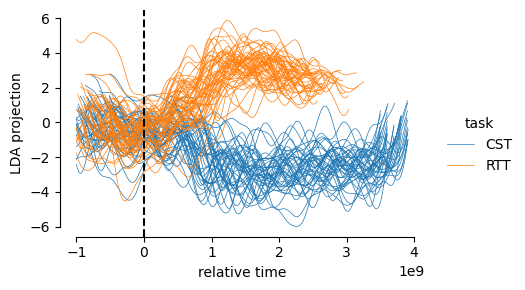

In [8]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from src.crystal_models import SoftnormScaler

lda_pipe = Pipeline([
    # ('preprocess', SoftnormScaler()),
    ('pca', PCA(n_components=15)),
    ('lda', LinearDiscriminantAnalysis()),
])

data = (
    pd.concat([
        tf.xs('CST',level='task',drop_level=False),
        tf.xs('RTT',level='task',drop_level=False),
    ])
    ['motor cortex']
    .groupby('trial_id')
    .transform(smile_extract.smooth_data,dt=0.01,std=0.1,backend='convolve')
    .groupby('trial_id',group_keys=False)
    .apply(reindex_trial_from_event,event='Hold Center (Task Cue)')
    .pipe(SoftnormScaler().fit_transform)
)
train_data = (
    data
    .loc[(slice(None),slice('1 sec','3 sec')),:]
)

test_data = (
    data
    .loc[(slice(None),slice('-1 sec','4 sec')),:]
)

lda_pipe.fit(train_data,src.munge.get_index_level(train_data,'task'))

output = pd.DataFrame(
    lda_pipe.transform(test_data),
    index=test_data.index,
    columns=['LDA projection'],
)
g = sns.relplot(
    output,
    x='relative time',
    y='LDA projection',
    hue='task',
    hue_order=['CST','RTT'],
    kind='line',
    height=3,
    aspect=1.5,
    errorbar=None,
    estimator=None,
    units='trial_id',
    lw=0.5,
)
g.refline(x=0, linestyle='--', color='black')
sns.despine(fig= g.figure,trim=True)

Text(0.5, 1.0, 'CST vs RTT motor cortex firing rates')

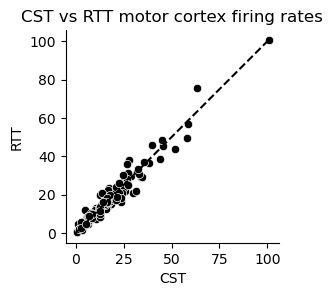

In [10]:
g = sns.relplot(
    data= (
        tf
        ['motor cortex']
        .stack()
        .groupby(['task','signal'])
        .mean()
        .unstack('task')
        / 0.01
    ),
    x='CST',
    y='RTT',
    height=3,
    color='black',
)
g.ax.set_aspect('equal')
g.ax.plot([0,100],[0,100],linestyle='--',color='black')
g.ax.set_title('CST vs RTT motor cortex firing rates')